# Negatively Correlated Channels

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig, Germany

This notebook is part of the paper "Copula-Based Multi-User Performance Bounds - Part II: Applications" ([doi:XXX](https://doi.org/XXX)).  
If you use any of this work, please cite the above paper.

> If you are not familiar with Jupyter notebooks: The easiest way to use this notebook interactively, is to hit `Kernel --> Restart & Run All` in the menu. The will execute all cells and enable the interactive elements of the plots.  
> Alternatively, you can execute the cells one by one using Shift+Return

In [1]:
import numpy as np
from scipy import stats
from scipy import optimize
from scipy import special
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

## Setup

We have two receivers who both receive a LOS signal at the same distance.
Next, they receive a reflected signal with a higher delay. The first receiver receives the reflected signal after $\tau_1 = \tau$ while the second receiver receives it later at $\tau_2 = \tau+\Delta\tau$.

The signal at receiver $r$ is given as
$$x_{r}(t) = A_1 \cos\left(\omega(t)\right) + A_{2}\cos\left(\omega(t-\tau_{r})\right)$$

In [2]:
def rec_signal(t, tau, t0=1., a1=1, a2=.5, omega=1):
    return a1*np.cos(omega*(t-t0)) + a2*np.cos(omega*(t-tau))

In [3]:
def plot_rec_signal():
    fig, ax1 = plt.subplots()
    t = np.linspace(0, 15, 100)
    plots = {1: ax1.plot(t, np.zeros(len(t)), label="Receiver 1")[0],
             2: ax1.plot(t, np.zeros(len(t)), label="Receiver 2")[0],
            }
    ax1.set_xlim([0, 15])
    ax1.set_ylim([-2, 2])
    ax1.set_xlabel("Time $t$")
    ax1.set_ylabel("Received Signal $x_{r}(t)$")
    plt.legend()
    def update_plot(tau=1, dtau=1, t0=0):
        for rec, plot in plots.items():
            if rec == 1:
                _tau = tau
            else:
                _tau = tau+dtau
            plot.set_ydata(rec_signal(t, _tau, t0=t0))
    interact(update_plot, tau=(1, 10, .2), dtau=(0, 7, .1), t0=(0, 1, .1))

<IPython.core.display.Javascript object>


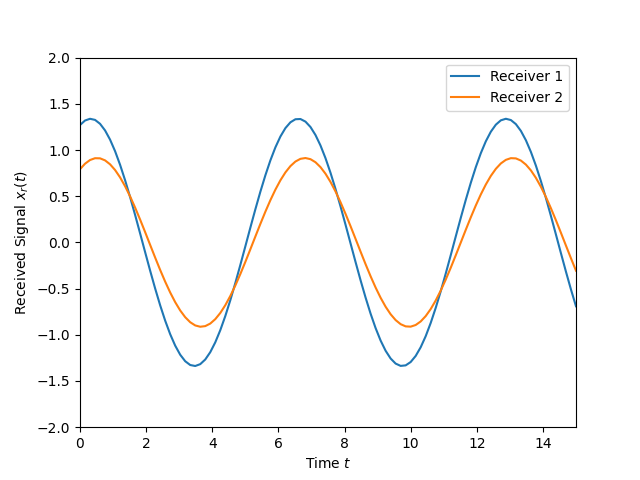

interactive(children=(FloatSlider(value=1.0, description='tau', max=10.0, min=1.0, step=0.2), FloatSlider(valu…

In [4]:
plot_rec_signal()

## Squared Envelope

In [5]:
def squared_envelope(tau, t0=0, a1=1, a2=.5, omega=1):
    _part1 = (a1*np.sin(omega*t0) + a2*np.sin(omega*tau))**2
    _part2 = (a1*np.cos(omega*t0) + a2*np.cos(omega*tau))**2
    return _part1 + _part2

In [6]:
def plot_rec_signal_with_envelope():
    fig, ax1 = plt.subplots()
    t = np.linspace(0, 15, 100)
    plot_rec1 = ax1.plot(t, np.zeros(len(t)), label="Receiver 1")[0]
    plot_rec2 = ax1.plot(t, np.zeros(len(t)), label="Receiver 2")[0]
    plot_env1 = ax1.plot(t, np.zeros(len(t)), label="Envelope 1")[0]
    plot_env2 = ax1.plot(t, np.zeros(len(t)), label="Envelope 2")[0]
    ax1.set_xlim([0, 15])
    ax1.set_ylim([-2, 2])
    ax1.set_xlabel("Time $t$")
    ax1.set_ylabel("Received Signal $x_{r}(t)$")
    plt.legend()
    def update_plot(tau=1, dtau=1, t0=0.):
        plot_rec1.set_ydata(rec_signal(t, tau, t0=t0))
        plot_rec2.set_ydata(rec_signal(t, tau+dtau, t0=t0))
        plot_env1.set_ydata(np.sqrt(squared_envelope(tau, t0=t0)))
        plot_env2.set_ydata(np.sqrt(squared_envelope(tau+dtau, t0=t0)))
    interact(update_plot, tau=(0, 10, .2), dtau=(0, 10, .1), t0=(1, 11, .1))

<IPython.core.display.Javascript object>


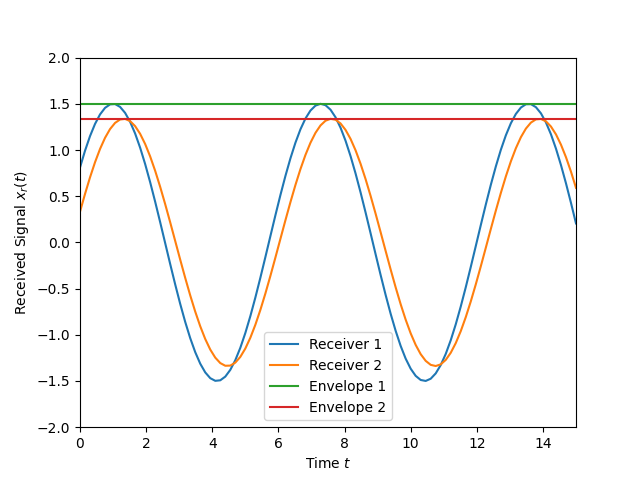

interactive(children=(FloatSlider(value=1.0, description='tau', max=10.0, step=0.2), FloatSlider(value=1.0, de…

In [7]:
plot_rec_signal_with_envelope()

In [8]:
def plot_envelope():
    fig, ax1 = plt.subplots()
    tau = np.linspace(0, 10, 100)
    plots = {1: ax1.plot(tau, np.zeros(len(tau)), label="Receiver 1")[0],
             2: ax1.plot(tau, np.zeros(len(tau)), label="Receiver 2")[0],
            }
    ax1.set_xlim([0, 10])
    ax1.set_ylim([0, 3])
    ax1.set_xlabel("Tau $\\tau$")
    ax1.set_ylabel("Squared Envelope $e_{r}^2$")
    plt.legend()
    def update_plot(dtau=1, t0=0.):
        for rec, plot in plots.items():
            if rec == 1:
                _tau = tau
            else:
                _tau = tau+dtau
            plot.set_ydata(squared_envelope(_tau, t0=t0))
    interact(update_plot, dtau=(0, 5, .1), t0=(5, 15, .2))

<IPython.core.display.Javascript object>


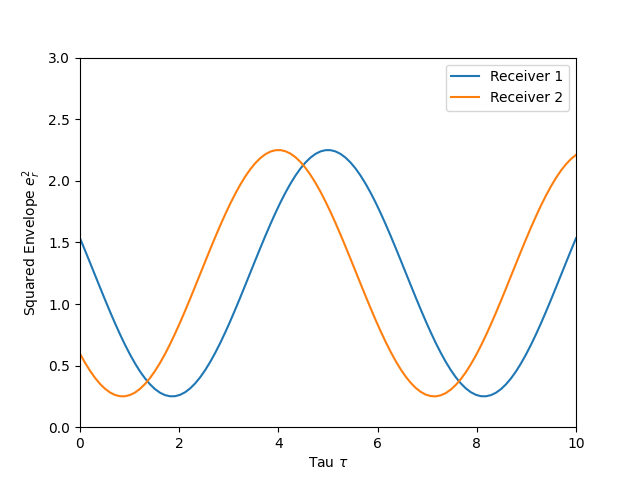

interactive(children=(FloatSlider(value=1.0, description='dtau', max=5.0), FloatSlider(value=5.0, description=…

In [9]:
plot_envelope()

## Correlation for Random Tau

We consider a fixed time difference between the arrivial of the first and second receiver, however the time delay is a random variable.

In [10]:
def scatter_envelopes(N=1000):
    fig, ax1 = plt.subplots()
    tau = np.abs(np.random.rand(N)+1)
    def update_plot(dtau=0, t0=0):
        ax1.clear()
        e1 = squared_envelope(tau, t0=t0)
        e2 = squared_envelope(tau+dtau, t0=t0)
        ax1.scatter(e1, e2)
        print(np.corrcoef(e1, e2))
    interact(update_plot, dtau=(0, 10, .05), t0=(0, 1, .1))

<IPython.core.display.Javascript object>


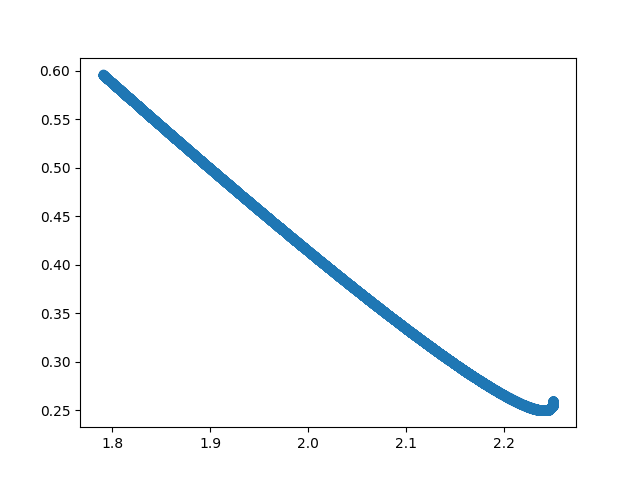

interactive(children=(FloatSlider(value=0.0, description='dtau', max=10.0, step=0.05), FloatSlider(value=0.0, …

In [11]:
scatter_envelopes(10000)

# Simulation with Random User Positions

Next, we run a quick and simple simulation where different users are placed around the transmitter. The transmitter is at position $(0, 0)$. The delay $\tau_0$ of the LOS component directly depends on the distance of the UE from the transmitter. For simplicity, we set it equal to it.

The delay of the first NLOS component $\tau_1=\tau$ is distributed uniformly as $\tau\sim\mathcal{U}[\tau_0, \tau_0+5]$. The delay between the two receive antennas is distributed according to a uniform distribution $\Delta\tau\sim\mathcal{U}[0, d]$.

In [12]:
def run_simulation(N=1000):
    fig, ax1 = plt.subplots()
    ax1.set_xlim([-2, 2])
    ax1.set_ylim([-2, 2])
    ax1.plot([0], [0], 'ro', label="Tx")
    pos = stats.uniform(-2, 4).rvs(size=(N, 2))
    ax1.scatter(pos[:, 0], pos[:, 1], label="Rx")
    ax1.legend()
    distances = np.linalg.norm(pos, axis=1)
    t0 = distances
    tau = 5*np.random.rand(N)+t0
    #dtau = d*np.random.rand(N)
    e1 = squared_envelope(tau, t0=t0)
    def update_plot(dtau=1):
        e2 = squared_envelope(tau+dtau, t0=t0)
        print(np.corrcoef(e1, e2))
    interact(update_plot, dtau=(0, 5, .1))

<IPython.core.display.Javascript object>


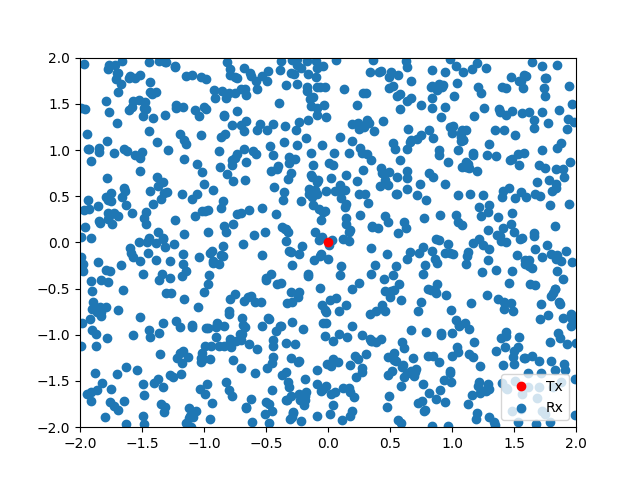

interactive(children=(FloatSlider(value=1.0, description='dtau', max=5.0), Output()), _dom_classes=('widget-in…

In [13]:
run_simulation()

## Second Simulation

In [14]:
def tau0(height, h_tx=10., dist=4, c=1):
    return c*np.sqrt(dist**2 + (h_tx-height)**2)

def tau1(height, h_tx=10., dist=4, c=1):
    dist_tx_r = np.sqrt(h_tx**2 + (dist*h_tx/(h_tx+height))**2)
    dist_r_rx = np.sqrt(height**2 + (dist*height/(h_tx+height))**2)
    return c * (dist_r_rx + dist_tx_r)

In [82]:
def single_receiver(distance=20):
    h_tx = 10.
    fig, ax1 = plt.subplots()
    ax1.hlines(0, 0, distance, lw=2)
    ax1.plot([0], [h_tx], 'o--')
    rx1 = ax1.plot([distance], [0], 'o', color='r', label="Rx1")[0]
    rx2 = ax1.plot([distance], [0], 'o', color='b', label="Rx2")[0]
    d01 = ax1.plot([0, distance], [h_tx, 0], '-', color='r')[0]
    d02 = ax1.plot([0, distance], [h_tx, 0], '-', color='b')[0]
    d11 = ax1.plot([0, distance/2, distance], [h_tx, 0, 0], '--', color='r')[0]
    d12 = ax1.plot([0, distance/2, distance], [h_tx, 0, 0], '--', color='b')[0]
    ax1.legend()
    def update_plot(h_1=1, delta_h=1):
        #ax1.clear()
        h_2 = h_1 + delta_h
        l_1 = distance*h_tx/(h_1+h_tx)
        l_2 = distance*h_tx/(h_2+h_tx)
        rx1.set_ydata(h_1)
        d01.set_ydata([h_tx, h_1])
        d02.set_ydata([h_tx, h_2])
        d11.set_data([0, l_1, distance], [h_tx, 0, h_1])
        d12.set_data([0, l_2, distance], [h_tx, 0, h_2])
        rx2.set_ydata(h_2)
        print("Rx1:\ttau0 = {:.3f}\ttau1 = {:.3f}".format(tau0(h_1, h_tx=h_tx, dist=distance),
                                                      tau1(h_1, h_tx=h_tx, dist=distance)))
        print("Rx2:\ttau0 = {:.3f}\ttau1 = {:.3f}".format(tau0(h_2, h_tx=h_tx, dist=distance),
                                                      tau1(h_2, h_tx=h_tx, dist=distance)))
    interact(update_plot, h_1=(1, 5, .2), delta_h=(1, 3, .1))

<IPython.core.display.Javascript object>


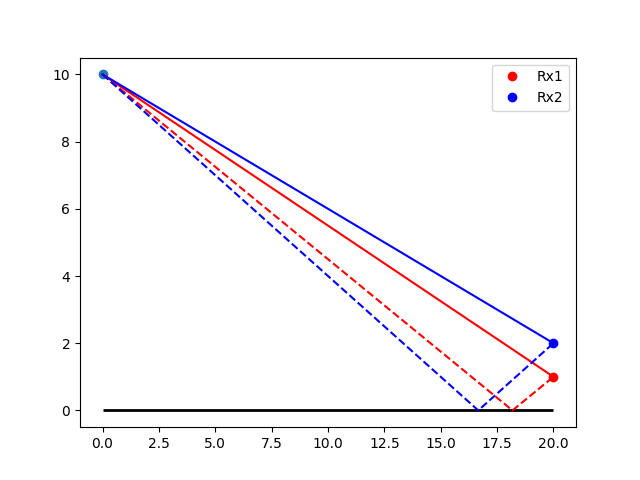

interactive(children=(FloatSlider(value=1.0, description='h_1', max=5.0, min=1.0, step=0.2), FloatSlider(value…

In [88]:
single_receiver()

In [118]:
from probability_bounds import export_results

def envelopes_over_distance(h_tx=10., export=False):
    fig, ax1 = plt.subplots()
    distances = np.linspace(1, 50, 100)
    results = {"distance": distances}
    plot1 = ax1.plot(distances, np.zeros(len(distances)))[0]
    plot2 = ax1.plot(distances, np.zeros(len(distances)))[0]
    ax1.set_xlim([min(distances), max(distances)])
    ax1.set_ylim([0, 3])
    def update_plot(h_1=1, delta_h=1):
        h_2 = h_1 + delta_h
        tau0_1 = tau0(h_1, h_tx=h_tx, dist=distances)
        tau1_1 = tau1(h_1, h_tx=h_tx, dist=distances)
        tau0_2 = tau0(h_2, h_tx=h_tx, dist=distances)
        tau1_2 = tau1(h_2, h_tx=h_tx, dist=distances)
        e1 = squared_envelope(tau1_1, t0=tau0_1)
        e2 = squared_envelope(tau1_2, t0=tau0_2)
        print(np.corrcoef(e1, e2))
        plot1.set_ydata(e1)
        plot2.set_ydata(e2)
        if export:
            results["x1"] = e1
            results["x2"] = e2
            filename = "rec_evelopes-htx{}-h1{}-dh{}.dat".format(h_tx, h_1, delta_h)
            export_results(results, filename)
    interact(update_plot, h_1=(1, 10, .2), delta_h=(1, 5, .1))

<IPython.core.display.Javascript object>


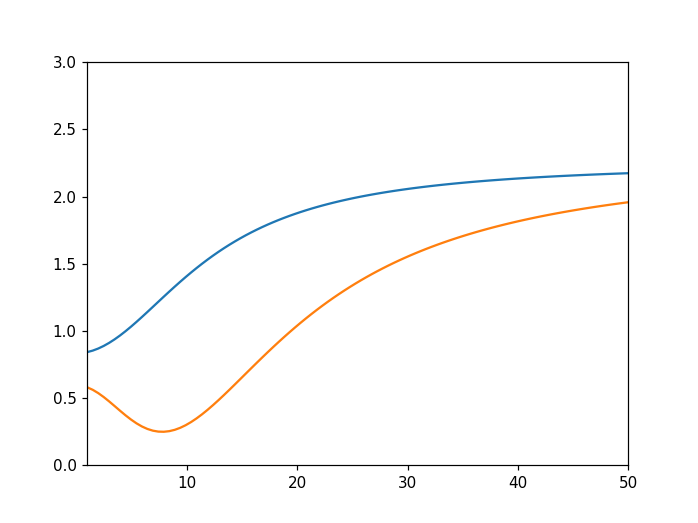

interactive(children=(FloatSlider(value=1.0, description='h_1', max=10.0, min=1.0, step=0.2), FloatSlider(valu…

In [119]:
envelopes_over_distance()

In [86]:
def run_simulation2(N=1000):
    fig, ax1 = plt.subplots()
    ax1.set_xlim([-20, 20])
    ax1.set_ylim([-20, 20])
    ax1.plot([0], [0], 'ro', label="Tx")
    pos = stats.uniform(-20, 40).rvs(size=(N, 2))
    ax1.scatter(pos[:, 0], pos[:, 1], label="Rx")
    ax1.legend()
    height_tx = 10.
    height_1 = 1 #2*np.random.rand(N) + 1
    distances = np.linalg.norm(pos, axis=1)
    tau0_1 = tau0(height_1, h_tx=height_tx, dist=distances)
    tau1_1 = tau1(height_1, h_tx=height_tx, dist=distances)
    e1 = squared_envelope(tau1_1, t0=tau0_1)
    def update_plot(delta_h=1):
        height_2 = delta_h + height_1
        tau0_2 = tau0(height_2, h_tx=height_tx, dist=distances)
        tau1_2 = tau1(height_2, h_tx=height_tx, dist=distances)
        e2 = squared_envelope(tau1_2, t0=tau0_2)
        print(np.corrcoef(e1, e2))
    interact(update_plot, delta_h=(.5, 4, .1))

<IPython.core.display.Javascript object>


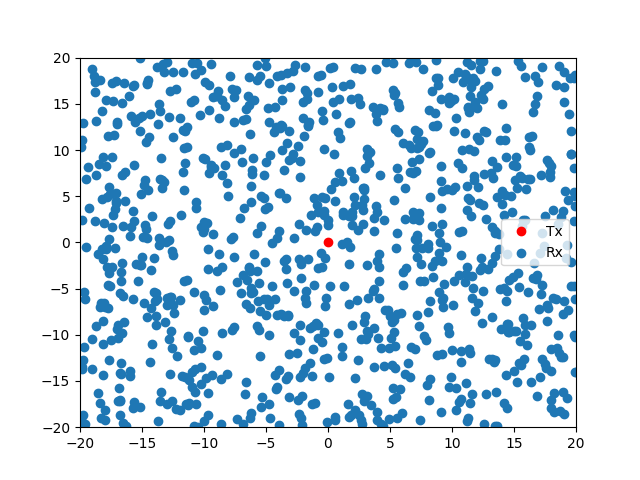

interactive(children=(FloatSlider(value=1.0, description='delta_h', max=4.0, min=0.5), Output()), _dom_classes…

In [87]:
run_simulation2()